# Keep in mind for this exercise :
## Advanced Feature Engineering: 
Diving deeper into techniques like polynomial features, interaction terms, and domain-specific transformations. 
These can sometimes dramatically improve model performance.

In [1]:
# EDA 
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#%% Set project directory
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
print(project_root)
sys.path.append(os.path.abspath(project_root))
from utils import load_config

/Users/aboubakr/ML-100-Projects/beginner/p2_TitanicSurvival


In [3]:
#%% Fetch configs paths
config_path = os.path.join(project_root, 'config.json')
config = load_config(config_path)
train_path = os.path.join(project_root, config["train_path"])
train_path

'/Users/aboubakr/ML-100-Projects/beginner/p2_TitanicSurvival/data/train.csv'

In [4]:
df = pd.read_csv(train_path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Pclass is ticket class, sibsp : amount of siblings/spouses aboard, parch : # parents and children , embarked : port of embarkation
df = df.drop(columns='PassengerId')

In [6]:
#There are a lot of missing values in Cabin, some in age and few in Embarked : we are going to need to handle those in preprocessing

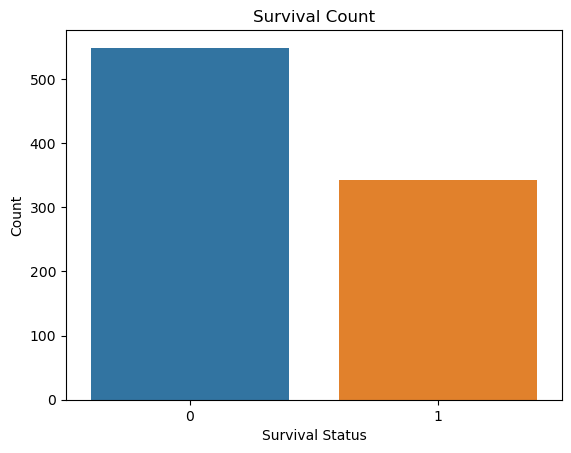

In [7]:
# Survival Distribution
sns.countplot(x='Survived', data=df)
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

In [8]:
#Survival rate per sex
df.groupby(['Sex', 'Survived'])['Survived'].count()
#We can see that there was 25% death for females and approx 80% for men sex looks like a key feature

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

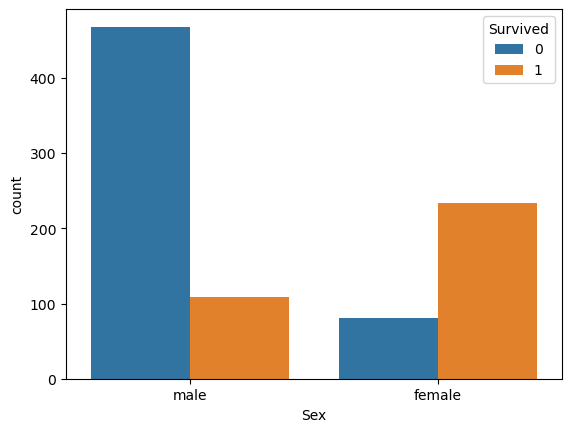

In [9]:
df['Survived'] = df['Survived'].astype(str)
sns.countplot(x='Sex',data=df,hue='Survived')
plt.show()

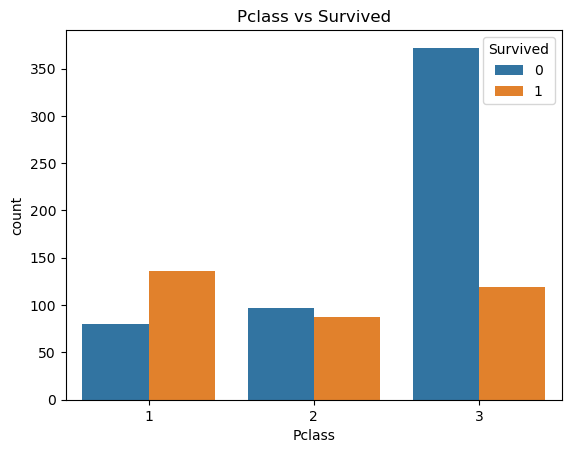

In [10]:
# Another intuition would be to check class and survival
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Pclass vs Survived')
plt.show()
# We can see that surival rate get's lower and lower when the class decreases. Intuition validated. Class is a key feature

In [11]:
#Let's extract the title from the name as class seems important, social status could be as well
#name = lastname, title . name
#df['Title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0])
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.')

In [12]:
pd.crosstab(df.Title,df.Sex).T.style.background_gradient(cmap='summer_r')

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [13]:
#Let's create a mapping of these features
title_map = {'Capt':'Mr',
             'Col' : 'Mr',
             'Countess' :'Mrs',
             'Don' : 'Mr',
             'Dr' : 'Mr',
             'Jonkheer' : 'Mr',
             'Lady' : 'Mrs',
             'Major' : 'Mr',
             'Master' : 'Master',
             'Miss' : 'Miss',
             'Mlle' : 'Miss',
             'Mme' : 'Mrs',
             'Mr' : 'Mr',
             'Mrs' : 'Mrs',
             'Ms' : 'Mrs',
             'Rev' : 'Mr',
             'Sir' : 'Mr'}
df.Title = df.Title.replace(title_map)
df.Title.value_counts()

Title
Mr        538
Miss      184
Mrs       129
Master     40
Name: count, dtype: int64

In [14]:
with open(os.path.join(project_root,'models/title_map.json'),"w") as outfile:
    json.dump(title_map, outfile, indent = 4)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


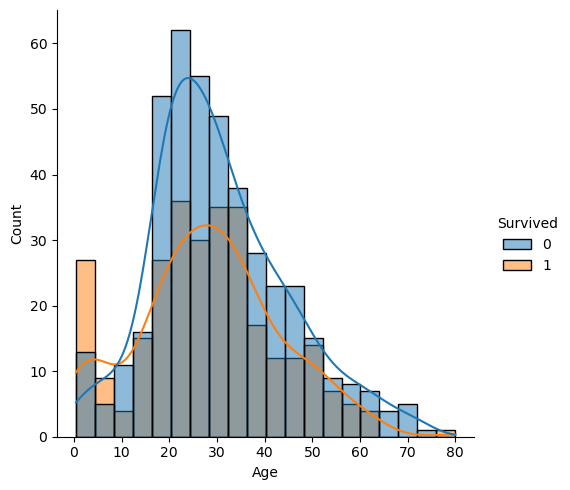

In [15]:
# Age distribution
sns.displot(data=df, x="Age", kde=True, hue = 'Survived')
#There's something gaussian like

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


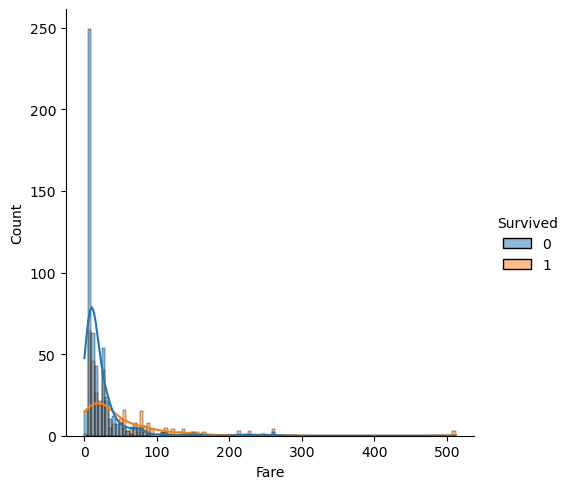

In [16]:
# Age distribution
sns.displot(data=df, x="Fare", kde=True, hue = 'Survived')
#There fare's distribution looks exponential we will apply a log on it

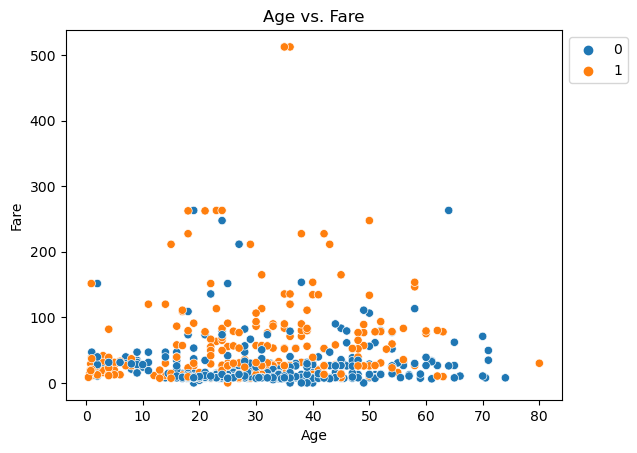

In [17]:
# Age vs Fare
sns.scatterplot(x='Age', y='Fare', 
				hue='Survived', data=df, ) 

# Placing Legend outside the Figure 
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
plt.title('Age vs. Fare')
plt.show()
#Nice plot but not much to learn

In [18]:
# Some Gaussian Mixed going on https://scikit-learn.org/stable/modules/mixture.html

In [19]:
# Let's check SibSp
pd.crosstab([df.SibSp],df.Survived).style.background_gradient('summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


In [20]:
# A lonely passenger has a 1/3 survival rate, when he's with one sibling or spouse, that jumps to nearly 1/2.
# and then that number decreases when siblings or spouses increase
# There's a feature here : lonely, couple, other

In [21]:
# Let's check Parch
pd.crosstab([df.Parch],df.Survived).style.background_gradient('summer_r')
# Similar behaviour than Sibsp

Survived,0,1
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


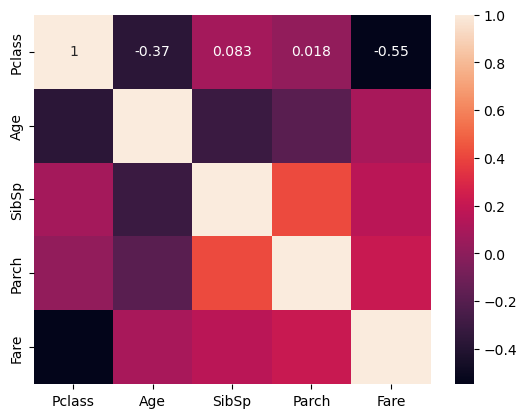

In [22]:
numeric_df = df.select_dtypes(include=[float, int])
sns.heatmap(numeric_df.corr(method='pearson'), annot = True)
plt.show()
#Variables are not that correlated we can keep them all

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    object 
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
 11  Title     891 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 83.7+ KB


In [24]:
df.Embarked.value_counts()
# this only misses 2 values we can fill tjem with 'S'
#'Cabin' is not giving much informations we won't be using it
#Age is going to be filled mith the mean

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [25]:
pd.crosstab([df.Embarked],df.Survived).style.background_gradient('summer_r')
#Interesting at Southampton : survival ratr is 1/3

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


In [26]:
numeric_mean = df.mean(axis=0, numeric_only=True).to_dict()
with open(os.path.join(project_root,'models/numeric_means.json'),"w") as outfile:
    json.dump(numeric_mean, outfile, indent = 4)

In [27]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Title']
target = 'Survived'